In [1]:
import os
import pickle

import numpy as np
import torch
from dreifus.camera import PoseType, CameraCoordinateConvention
from dreifus.image import normalized_torch_to_numpy_img
from dreifus.matrix import Pose
from eg3d.datamanager.nersemble import encode_camera_params
from matplotlib import pyplot as plt

from gghead.constants import DEFAULT_INTRINSICS
from gghead.model_manager.gghead_model_manager import GGHeadModelFolder
from gghead.models.gaussian_discriminator import GaussianDiscriminator
from gghead.models.gghead_model import GGHeadModel

if os.name == 'nt' and 'CONDA_PREFIX' in os.environ:
    # Necessary hack as on some systems, conda sometimes installs C++ headers into "Library/include" instead of just "include" ... 
    os.environ["NVCC_PREPEND_FLAGS"] = f"-I{os.environ['CONDA_PREFIX']}\Library\include"

Error loading vtkCommonComputationalGeometry-9.3-23851dd994e99bedbd8909ea204bcdcd.dll; The handle is invalid.


This notebook showcases how to load a pretrained `GGHead` model and use it to generate 3D Gaussian Heads.  


In [7]:
model_folder = GGHeadModelFolder()
for run_name in model_folder.list_runs():
    available_checkpoints = model_folder.open_run(run_name).list_checkpoint_ids()
    print(f" - {run_name}: {available_checkpoints}")

 - GGHEAD-1_ffhq512: [23200]
 - GGHEAD-2_ffhq1024: [23400]
 - GGHEAD-3_afhq512: [28600]


In [13]:
device = torch.device('cuda')
run_name = 'GGHEAD-1'  # <- Specify which model you would like to load
checkpoint = 23200  # <- Specify the checkpoint to load

model_manager = model_folder.open_run(run_name)

In [6]:
# ignore_keys = ['dataset_label_std']
# snapshot = dict()
# 
# model_config = model_manager.load_model_config()
# model_G = GGHeadModel(model_config.generator_config)
# model_G_ema = GGHeadModel(model_config.generator_config)
# model_D = GaussianDiscriminator(model_config.discriminator_config)
# state_dict_G = torch.load(f"{model_manager.get_checkpoint_folder()}/checkpoint-{checkpoint}_G.pt")
# state_dict_G_ema = torch.load(f"{model_manager.get_checkpoint_folder()}/checkpoint-{checkpoint}_G_ema.pt")
# state_dict_D = torch.load(f"{model_manager.get_checkpoint_folder()}/checkpoint-{checkpoint}_D.pt")
# 
# model_G.load_state_dict({k: p for k, p in state_dict_G.items() if k not in ignore_keys})
# model_G_ema.load_state_dict({k: p for k, p in state_dict_G_ema.items() if k not in ignore_keys})
# model_D.load_state_dict({k: p for k, p in state_dict_D.items() if k not in ignore_keys})
# snapshot['G'] = model_G
# snapshot['G_ema'] = model_G_ema
# snapshot['D'] = model_D
# with open(f"{model_manager.get_checkpoint_folder()}/checkpoint-{checkpoint}.pkl", 'wb') as f:
#     pickle.dump(snapshot, f)

C:\Users\tkirschstein\AppData\Local\Temp\ipykernel_66760\3413314633.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict_G = torch.load(f"{model_manager.get_checkp

In [14]:
# Load the specified checkpoint
model = model_manager.load_checkpoint(checkpoint, load_ema=True)
model = model.to(device)

In [15]:
# Change the render camera to your liking. Per default, it will render the 3D head from the front at 2.7 units distance
pose_front = Pose(
    matrix_or_rotation=np.eye(3),
    translation=(0, 0, 2.7),
    pose_type=PoseType.CAM_2_WORLD,
    camera_coordinate_convention=CameraCoordinateConvention.OPEN_GL)
c_front = encode_camera_params(pose_front, DEFAULT_INTRINSICS)
c_front = torch.from_numpy(c_front).cuda().unsqueeze(0)

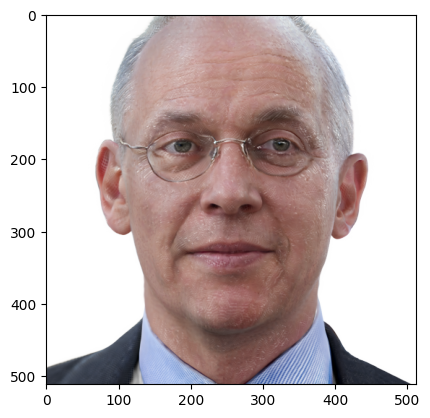

In [16]:
# Generate and render a 3D head corresponding to a random seed 
seed = 0
render_resolution = model_manager.load_dataset_config().resolution

rng = torch.Generator(device)
rng.manual_seed(seed)
z = torch.randn((1, model.z_dim), device='cuda', generator=rng)
w = model.mapping(z, c_front, truncation_psi=0.7)
output = model.synthesis(w, c_front, noise_mode='const', return_masks=True, 
                         #sh_ref_cam=pose_front, 
                         neural_rendering_resolution=render_resolution)
image = output['image']
image = normalized_torch_to_numpy_img(image[0])
plt.imshow(image)
plt.show()